In [ ]:
import numpy as np
import pandas as pd
import requests

token_1='82908162e488cf6a1e53620862cd2d9fa1181ba5a78882ffeb5d29320a19a145'

def descargar_banxico(serie,fecha_inicio,fecha_fin,token=token_1,es_oportuno=False):
    #Donde:
    # serie: el identificador o identificadores que tiene Banxico para cada serie de tiempo en su sistema de información
    #       las series se pueden consultar en la siguiente liga: https://www.banxico.org.mx/SieAPIRest/service/v1/doc/catalogoSeries
    # fecha_inicio: fecha aaaa-mm-dd en la que se quiere iniciar la consulta
    # fecha_fin: fecha aaaa-mm-dd en la que se quiere concluir la consulta
    # token: el token generado por la API de Banxico para acceder

    if es_oportuno==True:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/oportuno?token='+token
    else:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/'+fecha_inicio+'/'+fecha_fin+'?token='+token
    headers = {'Token':token}
    response = requests.get(url,headers=headers)
    status=response.status_code
    raw_data = response.json()
    T=len(serie.split(","))
    info={'fecha':pd.DataFrame(raw_data['bmx']['series'][0]['datos'])['fecha']}

    for i in range(T):
        titulo=raw_data['bmx']['series'][i]['titulo']

        data=raw_data['bmx']['series'][i]['datos']

        df=pd.DataFrame(data)
        df['dato'] = df['dato'].str.replace(',', '', regex=True).str.extract('(\d+\.\d+)')[0].astype(float)
        df['dato'] = df['dato'].apply(lambda x:float(x))
        info[titulo]=df['dato']
    info=pd.DataFrame(info)
    info.set_index('fecha',inplace=True)

    return info

def descargar_fred(serie,fecha_inicio,fecha_fin):
    key_2='fb3e12e05f3753283d1b617eee584598'
    url_2='https://api.stlouisfed.org/fred/series/observations?series_id='+serie+'&api_key='+key_2+'&file_type=json'
    response2 = requests.get(url_2)
    status=response2.status_code
    raw_data = response2.json()
    variable=pd.DataFrame(raw_data['observations'])[['date','value']]
    variable=variable.set_index(pd.to_datetime(list(variable.iloc[:,0]),format="%Y/%m/%d")).drop(['date'],axis=1)
    variable=variable.loc[fecha_inicio:fecha_fin]
    return pd.DataFrame(variable)

#pd.concat([ipi_us.iloc[:,0].apply(lambda x:float(x)),payroll.iloc[:,0].apply(lambda x:float(x))],axis=1)
def a_float(serie):
    return serie.iloc[:,0].apply(lambda x:float(x))

fecha_inicio='2002-01-01'
fecha_fin='2023-10-28'

ipi_us=descargar_fred('INDPRO',fecha_inicio,fecha_fin)
construc_us=descargar_fred('IPB54100S',fecha_inicio,fecha_fin)
manuf_us=descargar_fred('IPMAN',fecha_inicio,fecha_fin)
payroll=descargar_fred('PAYEMS',fecha_inicio,fecha_fin)
payroll=descargar_fred('PAYEMS',fecha_inicio,fecha_fin)
cpi_us=descargar_fred('CPIAUCSL','2001-01-01',fecha_fin)

igae=descargar_banxico('SR16734',fecha_inicio,fecha_fin)
remesas=descargar_banxico('SE27803',fecha_inicio,fecha_fin)
usdmxn_mensual=descargar_banxico('SF17908',fecha_inicio,fecha_fin)
usdmxn_diaria=descargar_banxico('SF43718',fecha_inicio,fecha_fin)
ifb=descargar_banxico('SR17459',fecha_inicio,fecha_fin)
inpc=descargar_banxico('SP1','2001-01-01',fecha_fin)
inpc=inpc.pct_change(12).iloc[12:,:]
cpi_us=a_float(cpi_us).pct_change(12).iloc[12:]
cpi_us=pd.DataFrame(cpi_us)
cpi_us[cpi_us['value']<0]=0.0005
corr=descargar_banxico('SE44352',fecha_inicio,fecha_fin)
salario=descargar_banxico('SL2827',fecha_inicio,fecha_fin)
subsid=descargar_banxico('SG52',fecha_inicio,fecha_fin)
ingtri=descargar_banxico('SG10',fecha_inicio,fecha_fin)


#fondeo es diaria, convertir a mensual
fondeo=descargar_banxico('SF43773',fecha_inicio,fecha_fin)
fondeo=fondeo.set_index(pd.to_datetime(list(fondeo.index),format="%d/%m/%Y")).resample('M').mean()
fondeo=fondeo.set_index([pd.date_range(start=fecha_inicio,end=fecha_fin,freq='MS')])


In [ ]:
#ESTE PEDAZO SOLO CORRERLO SI SE ESTÁ EJECUTANDO EN COLAB BY SE REQUIERE SUBIR UN ARCHIVO


#from google.colab import files
#uploaded = files.upload()

Saving IGAE.csv to IGAE.csv


In [ ]:
igae2=pd.read_csv('IGAE.csv').iloc[23:,:]
igae2=pd.DataFrame(igae2['IGAE']).set_index(pd.date_range(fecha_inicio,periods=remesas.shape[0],freq='MS'))

explicativas=pd.concat([remesas,usdmxn_mensual,ifb,inpc,ingtri,subsid,salario],axis=1).set_index(pd.to_datetime(list(inpc.index),format="%d/%m/%Y"))
explicativas=pd.concat([explicativas,fondeo,a_float(ipi_us),a_float(construc_us),a_float(manuf_us),a_float(payroll),a_float(cpi_us)],axis=1).iloc[:,:]#.apply(lambda x:x.pct_change(12)).ffill()
explicativas=pd.concat([igae2,explicativas],axis=1).ffill()
explicativas=pd.concat([explicativas,corr.set_index(pd.to_datetime(list(corr.index),format="%d/%m/%Y"))],axis=1).ffill().set_axis(['IGAE','Remesas','USDMXN','Inversión fija bruta','Inflación MX','Ingresos tributarios MX','Subsidios gob federal','Salarios reales MX','Tasa de fondeo','Producción industrial EEUU','Construcción EEUU', 'Producción manufacturera EEUU','Nómina no agrícola EEUU','Inflación EEUU','Cuenta corriente MX'],axis='columns')
explicativas1=explicativas.apply(lambda x:np.log(x))

from sklearn.model_selection import train_test_split
#explicativas1['IGAE']=explicativas['IGAE']
train_set, test_set = train_test_split(explicativas1, train_size=0.9, test_size=0.1, shuffle=False)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def build_dataset(X,Y, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples))

  min_max_scaler = MinMaxScaler()
  X = min_max_scaler.fit_transform(X.values)

  for ind in range(n_samples):
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size]
  return x, y

def x_y_split(df,variable='IGAE'):
  ytrain=df[variable]
  xtrain=df.drop([variable],axis=1)
  return xtrain,ytrain

 # ['IGAE','Remesas','USDMXN','Inversión fija bruta','Inflación MX','Tasa de fondeo','Producción industrial EEUU','Nómina no agrícola EEUU','Inflación EEUU','Cuenta corriente MX'].apply(lambda x:x_y_split(explicativas1,x))

In [ ]:
!pip install pmdarima
import pmdarima
prelim=explicativas1.apply(lambda x:pmdarima.arima.auto_arima(x,error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00


In [ ]:
prelim1=np.transpose(prelim.apply(lambda x:x.predict(18)))
prelim1=pd.concat([explicativas1,prelim1],axis=0)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, SimpleRNN, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM

  # Create RNN model
def correr_rnn(x_train,y_train,epocas=120,batches=6,nodo_in=32,nodos=[128,128,64],activac=['sigmoid','sigmoid','relu'],num_convol=12):
    x_train,y_train=build_dataset(x_train,y_train,num_convol)
    rnn_model = Sequential()
    rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    rnn_model.add(SimpleRNN(units=nodo_in))
    for i in range(len(nodos)):
        rnn_model.add(Dense(nodos[i], activation=activac[i]))
    rnn_model.add(Dense(1, activation='linear'))
    rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return rnn_model,rnn_model.fit(x_train, y_train, epochs=epocas, batch_size=batches, validation_split=0.1,verbose=0)

def correr_lstm(x_train,y_train,epocas=120,batches=6,nodo_in=32,nodos=[128,128,64],activac=['sigmoid','sigmoid','relu'],num_convol=12):
    x_train,y_train=build_dataset(x_train,y_train,num_convol)
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    lstm_model.add(LSTM(units=nodo_in))
    for i in range(len(nodos)):
        lstm_model.add(Dense(nodos[i], activation=activac[i]))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return lstm_model,lstm_model.fit(x_train, y_train, epochs=epocas, batch_size=batches, validation_split=0.1,verbose=0)

grids1={'epocas':[100],'batches':[4,8,16,24],
    'nodo_in':[32,64],'nodos':[[128,128,64],[64,64,64],[64,128,64],[64,128,128],[64,128],[128,64]],
        'activac':[['sigmoid','sigmoid','relu'],['sigmoid','sigmoid','relu'],['sigmoid','sigmoid','relu'],['sigmoid','sigmoid','relu'],['sigmoid','sigmoid'],['sigmoid','sigmoid']]}


In [ ]:
convol=12

def correr_red(func_red=correr_rnn,variable='IGAE',num_convol=convol,prelim0=prelim1,grids=grids1):
    rnn_set=[]
    corridas_rnn_set=[]
    fit_inicial=[]
    rmse_rnn_train=[]
    rmse_rnn_test=[]
    x_set,y_set=x_y_split(explicativas1,variable)
    x_fit,y_fit=x_y_split(prelim0,variable)
    x_fit,y_fit=build_dataset(x_fit,y_fit,num_convol)
    count=0
    for i in range(len(grids['nodo_in'])):
        for j in range(len(grids['nodos'])):
            for k in range(len(grids['epocas'])):
                for l in range(len(grids['batches'])):
                    red,cor=func_red(x_set,y_set,grids['epocas'][k],grids['batches'][l],grids['nodo_in'][i],grids['nodos'][j],grids['activac'][j],num_convol)
                    rnn_set.append(red)
                    fit_inicial.append(pd.DataFrame(red.predict(x_fit)).set_index(prelim0.index[num_convol:]))
                    corridas_rnn_set.append(cor)
                    print('termina modelo '+str(count)+' de '+str(variable)+' de '+str(func_red))
                    count=count+1
                    rmse_rnn_train.append([cor.history['loss'][-1]])
                    rmse_rnn_test.append([cor.history['val_loss'][-1]])
    return [rnn_set,corridas_rnn_set,fit_inicial,rmse_rnn_train,rmse_rnn_test]

def modelo_menor_rmse(red=modelo_igae_rnn):
    red=pd.DataFrame({})
    for i in range(len(red[2])):
        red=pd.concat([red,pd.DataFrame(red[2][i])],axis=1)
    red=red.set_axis([list(range(len(red[2])))],axis=1)
    from sklearn.metrics import mean_squared_error
    rmses=pd.DataFrame({})
    for i in range(len(red[2])):
        rmses=pd.concat([rmses,pd.DataFrame([mean_squared_error(red[i][:train_set.shape[0]-convol],train_set['IGAE'][convol:],squared=False),
            mean_squared_error(red[i][train_set.shape[0]-convol:test_set.shape[0]+train_set.shape[0]-convol],test_set['IGAE'],squared=False)],index=['RMSE train','RMSE test'])],axis=1)
    rmses=rmses.set_axis([list(range(len(red[2])))],axis=1)
    mayor=np.argmin(rmses.iloc[1,:])
    return red[mayor]


In [ ]:
explicativas1.columns

Index(['IGAE', 'Remesas', 'USDMXN', 'Inversión fija bruta', 'Inflación MX',
       'Ingresos tributarios MX', 'Subsidios gob federal',
       'Salarios reales MX', 'Tasa de fondeo', 'Producción industrial EEUU',
       'Construcción EEUU', 'Producción manufacturera EEUU',
       'Nómina no agrícola EEUU', 'Inflación EEUU', 'Cuenta corriente MX'],
      dtype='object')

## Sección para seleccionar el mejor modelo

In [ ]:
#para correr gridsearch de cada variable usar las funciones comentadas. Para correr una red en particular, usar la función correr_rnn

grids_prueba={'epocas':[50,8],'batches':[4],
    'nodo_in':[32,64],'nodos':[[128,128,64]],
        'activac':[['sigmoid','sigmoid','relu']]}
modelo_igae_rnn=correr_red(correr_rnn,'IGAE',convol,prelim1,grids=grids_prueba)
#modelo_igae_lstm=correr_red(correr_lstm,'IGAE',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 2ms/step
termina modelo 0 de IGAE de <function correr_rnn at 0x7ce2fe31edd0>
9/9 [==============================] - 0s 2ms/step
termina modelo 1 de IGAE de <function correr_rnn at 0x7ce2fe31edd0>
9/9 [==============================] - 0s 2ms/step
termina modelo 2 de IGAE de <function correr_rnn at 0x7ce2fe31edd0>
9/9 [==============================] - 0s 2ms/step
termina modelo 3 de IGAE de <function correr_rnn at 0x7ce2fe31edd0>


In [ ]:
modelo_remesas_rnn=correr_red(correr_rnn,'Remesas',convol,prelim1,grids=grids1)
modelo_remesas_lstm=correr_red(correr_lstm,'Remesas',convol,prelim1,grids=grids1)


9/9 [==============================] - 0s 3ms/step
*************************************************************************************************
************************termina modelo 0 de Remesasde<function correr_rnn at 0x7e74a78c6b90>**c***********
*************************************************************************************************
9/9 [==============================] - 0s 5ms/step
*************************************************************************************************
************************termina modelo 1 de Remesasde<function correr_rnn at 0x7e74a78c6b90>**c***********
*************************************************************************************************
9/9 [==============================] - 0s 3ms/step
*************************************************************************************************
************************termina modelo 2 de Remesasde<function correr_rnn at 0x7e74a78c6b90>**c***********
************************************

In [ ]:
modelo_ifb_rnn=correr_red(correr_rnn,'Inversión fija bruta',convol,prelim1,grids=grids1)
modelo_ifb_lstm=correr_red(correr_lstm,'Inversión fija bruta',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 2ms/step
************************termina modelo 0 de Inversión fija bruta de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 1 de Inversión fija bruta de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 2 de Inversión fija bruta de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 3 de Inversión fija bruta de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 4 de Inversión fija bruta de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 5 de Inversión fija bruta de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/

In [ ]:
modelo_usdmxn_rnn=correr_red(correr_rnn,'USDMXN',convol,prelim1,grids=grids1)
modelo_usdmxn_lstm=correr_red(correr_lstm,'USDMXN',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 3ms/step
************************termina modelo 0 de USDMXN de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 1 de USDMXN de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 2 de USDMXN de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 3 de USDMXN de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 4 de USDMXN de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 5 de USDMXN de <function correr_rnn at 0x7e36f92b77f0>
9/9 [==============================] - 0s 2ms/step
************************termina modelo 6 de USDMXN de <function correr_rnn at 0

In [ ]:
modelo_inpc_rnn=correr_red(correr_rnn,'Inflación MX',convol,prelim1,grids=grids1)
modelo_inpc_lstm=correr_red(correr_lstm,'Inflación MX',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 3ms/step
termina modelo 0 de Inflación MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 1 de Inflación MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 2 de Inflación MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 3 de Inflación MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 4 de Inflación MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 5 de Inflación MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 6 de Inflación MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 7 de Inflación MX de <function correr_rnn at 

In [ ]:
modelo_intrib_rnn=correr_red(correr_rnn,'Ingresos tributarios MX',convol,prelim1,grids=grids1)
modelo_intrib_lstm=correr_red(correr_lstm,'Ingresos tributarios MX',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 3ms/step
termina modelo 0 de Ingresos tributarios MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 1 de Ingresos tributarios MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 2 de Ingresos tributarios MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 4ms/step
termina modelo 3 de Ingresos tributarios MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 4 de Ingresos tributarios MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 5 de Ingresos tributarios MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [==============================] - 0s 3ms/step
termina modelo 6 de Ingresos tributarios MX de <function correr_rnn at 0x793db0e3d5a0>
9/9 [=============================

In [ ]:
modelo_subsid_rnn=correr_red(correr_rnn,'Subsidios gob federal',convol,prelim1,grids=grids1)
modelo_subsid_lstm=correr_red(correr_lstm,'Subsidios gob federal',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 3ms/step
termina modelo 0 de Subsidios gob federal de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 5ms/step
termina modelo 1 de Subsidios gob federal de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 2 de Subsidios gob federal de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 3 de Subsidios gob federal de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 4 de Subsidios gob federal de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 5 de Subsidios gob federal de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 6 de Subsidios gob federal de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/st

In [ ]:
modelo_salario_rnn=correr_red(correr_rnn,'Salarios reales MX',convol,prelim1,grids=grids1)
modelo_salario_lstm=correr_red(correr_lstm,'Salarios reales MX',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 4ms/step
termina modelo 0 de Salarios reales MX de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 1 de Salarios reales MX de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 2 de Salarios reales MX de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 3 de Salarios reales MX de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 4 de Salarios reales MX de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 5 de Salarios reales MX de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 4ms/step
termina modelo 6 de Salarios reales MX de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 7 d

In [ ]:
modelo_fondeo_rnn=correr_red(correr_rnn,'Tasa de fondeo',convol,prelim1,grids=grids1)
modelo_fondeo_lstm=correr_red(correr_lstm,'Tasa de fondeo',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 3ms/step
termina modelo 0 de Tasa de fondeo de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 1 de Tasa de fondeo de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 2 de Tasa de fondeo de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 4ms/step
termina modelo 3 de Tasa de fondeo de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 4 de Tasa de fondeo de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 5 de Tasa de fondeo de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 6 de Tasa de fondeo de <function correr_rnn at 0x7c13a95a97e0>
9/9 [==============================] - 0s 3ms/step
termina modelo 7 de Tasa de fondeo de <functio

In [ ]:
modelo_indeu_rnn=correr_red(correr_rnn,'Producción industrial EEUU',convol,prelim1,grids=grids1)
modelo_indeu_lstm=correr_red(correr_lstm,'Producción industrial EEUU',convol,prelim1,grids=grids1)


9/9 [==============================] - 0s 2ms/step
termina modelo 0 de Producción industrial EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 1 de Producción industrial EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 2 de Producción industrial EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 3 de Producción industrial EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 4 de Producción industrial EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 5 de Producción industrial EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 6 de Producción industrial EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [========

In [ ]:
modelo_consteu_rnn=correr_red(correr_rnn,'Construcción EEUU',convol,prelim1,grids=grids1)
modelo_consteu_lstm=correr_red(correr_lstm,'Construcción EEUU',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 2ms/step
termina modelo 0 de Construcción EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 1 de Construcción EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 2 de Construcción EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 3 de Construcción EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 4 de Construcción EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 5 de Construcción EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 6 de Construcción EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 7 de Const

In [ ]:
modelo_manufeu_rnn=correr_red(correr_rnn,'Producción manufacturera EEUU',convol,prelim1,grids=grids1)
modelo_manufeu_lstm=correr_red(correr_lstm,'Producción manufacturera EEUU',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 2ms/step
termina modelo 0 de Producción manufacturera EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 1 de Producción manufacturera EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 2 de Producción manufacturera EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 3 de Producción manufacturera EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 3ms/step
termina modelo 4 de Producción manufacturera EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 5 de Producción manufacturera EEUU de <function correr_rnn at 0x7b100c46f880>
9/9 [==============================] - 0s 2ms/step
termina modelo 6 de Producción manufacturera EEUU de <function correr_rnn at 0x7b100c

In [ ]:
modelo_payroll_rnn=correr_red(correr_rnn,'Nómina no agrícola EEUU',convol,prelim1,grids=grids1)
modelo_payroll_lstm=correr_red(correr_lstm,'Nómina no agrícola EEUU',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 2ms/step
termina modelo 0 de Nómina no agrícola EEUU de <function correr_rnn at 0x7b100c53e170>
9/9 [==============================] - 0s 2ms/step
termina modelo 1 de Nómina no agrícola EEUU de <function correr_rnn at 0x7b100c53e170>
9/9 [==============================] - 0s 2ms/step
termina modelo 2 de Nómina no agrícola EEUU de <function correr_rnn at 0x7b100c53e170>
9/9 [==============================] - 0s 2ms/step
termina modelo 3 de Nómina no agrícola EEUU de <function correr_rnn at 0x7b100c53e170>
9/9 [==============================] - 0s 2ms/step
termina modelo 4 de Nómina no agrícola EEUU de <function correr_rnn at 0x7b100c53e170>
9/9 [==============================] - 0s 2ms/step
termina modelo 5 de Nómina no agrícola EEUU de <function correr_rnn at 0x7b100c53e170>
9/9 [==============================] - 0s 2ms/step
termina modelo 6 de Nómina no agrícola EEUU de <function correr_rnn at 0x7b100c53e170>
9/9 [=============================

In [ ]:
modelo_infeu_rnn=correr_red(correr_rnn,'Inflación EEUU',convol,prelim1,grids=grids1)
modelo_infeu_lstm=correr_red(correr_lstm,'Inflación EEUU',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 3ms/step
termina modelo 0 de Inflación EEUU de <function correr_rnn at 0x792bf5e13130>
9/9 [==============================] - 0s 3ms/step
termina modelo 1 de Inflación EEUU de <function correr_rnn at 0x792bf5e13130>
9/9 [==============================] - 0s 3ms/step
termina modelo 2 de Inflación EEUU de <function correr_rnn at 0x792bf5e13130>
9/9 [==============================] - 0s 4ms/step
termina modelo 3 de Inflación EEUU de <function correr_rnn at 0x792bf5e13130>
9/9 [==============================] - 0s 3ms/step
termina modelo 4 de Inflación EEUU de <function correr_rnn at 0x792bf5e13130>
9/9 [==============================] - 0s 3ms/step
termina modelo 5 de Inflación EEUU de <function correr_rnn at 0x792bf5e13130>
9/9 [==============================] - 0s 3ms/step
termina modelo 6 de Inflación EEUU de <function correr_rnn at 0x792bf5e13130>
9/9 [==============================] - 0s 3ms/step
termina modelo 7 de Inflación EEUU de <functio

In [ ]:
modelo_ccorr_rnn=correr_red(correr_rnn,'Cuenta corriente MX',convol,prelim1,grids=grids1)
modelo_ccorr_lstm=correr_red(correr_lstm,'Cuenta corriente MX',convol,prelim1,grids=grids1)

9/9 [==============================] - 0s 3ms/step
termina modelo 0 de Cuenta corriente MX de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 1 de Cuenta corriente MX de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 2 de Cuenta corriente MX de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 3 de Cuenta corriente MX de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 4ms/step
termina modelo 4 de Cuenta corriente MX de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 5 de Cuenta corriente MX de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina modelo 6 de Cuenta corriente MX de <function correr_rnn at 0x793c5cf6ff40>
9/9 [==============================] - 0s 3ms/step
termina mod

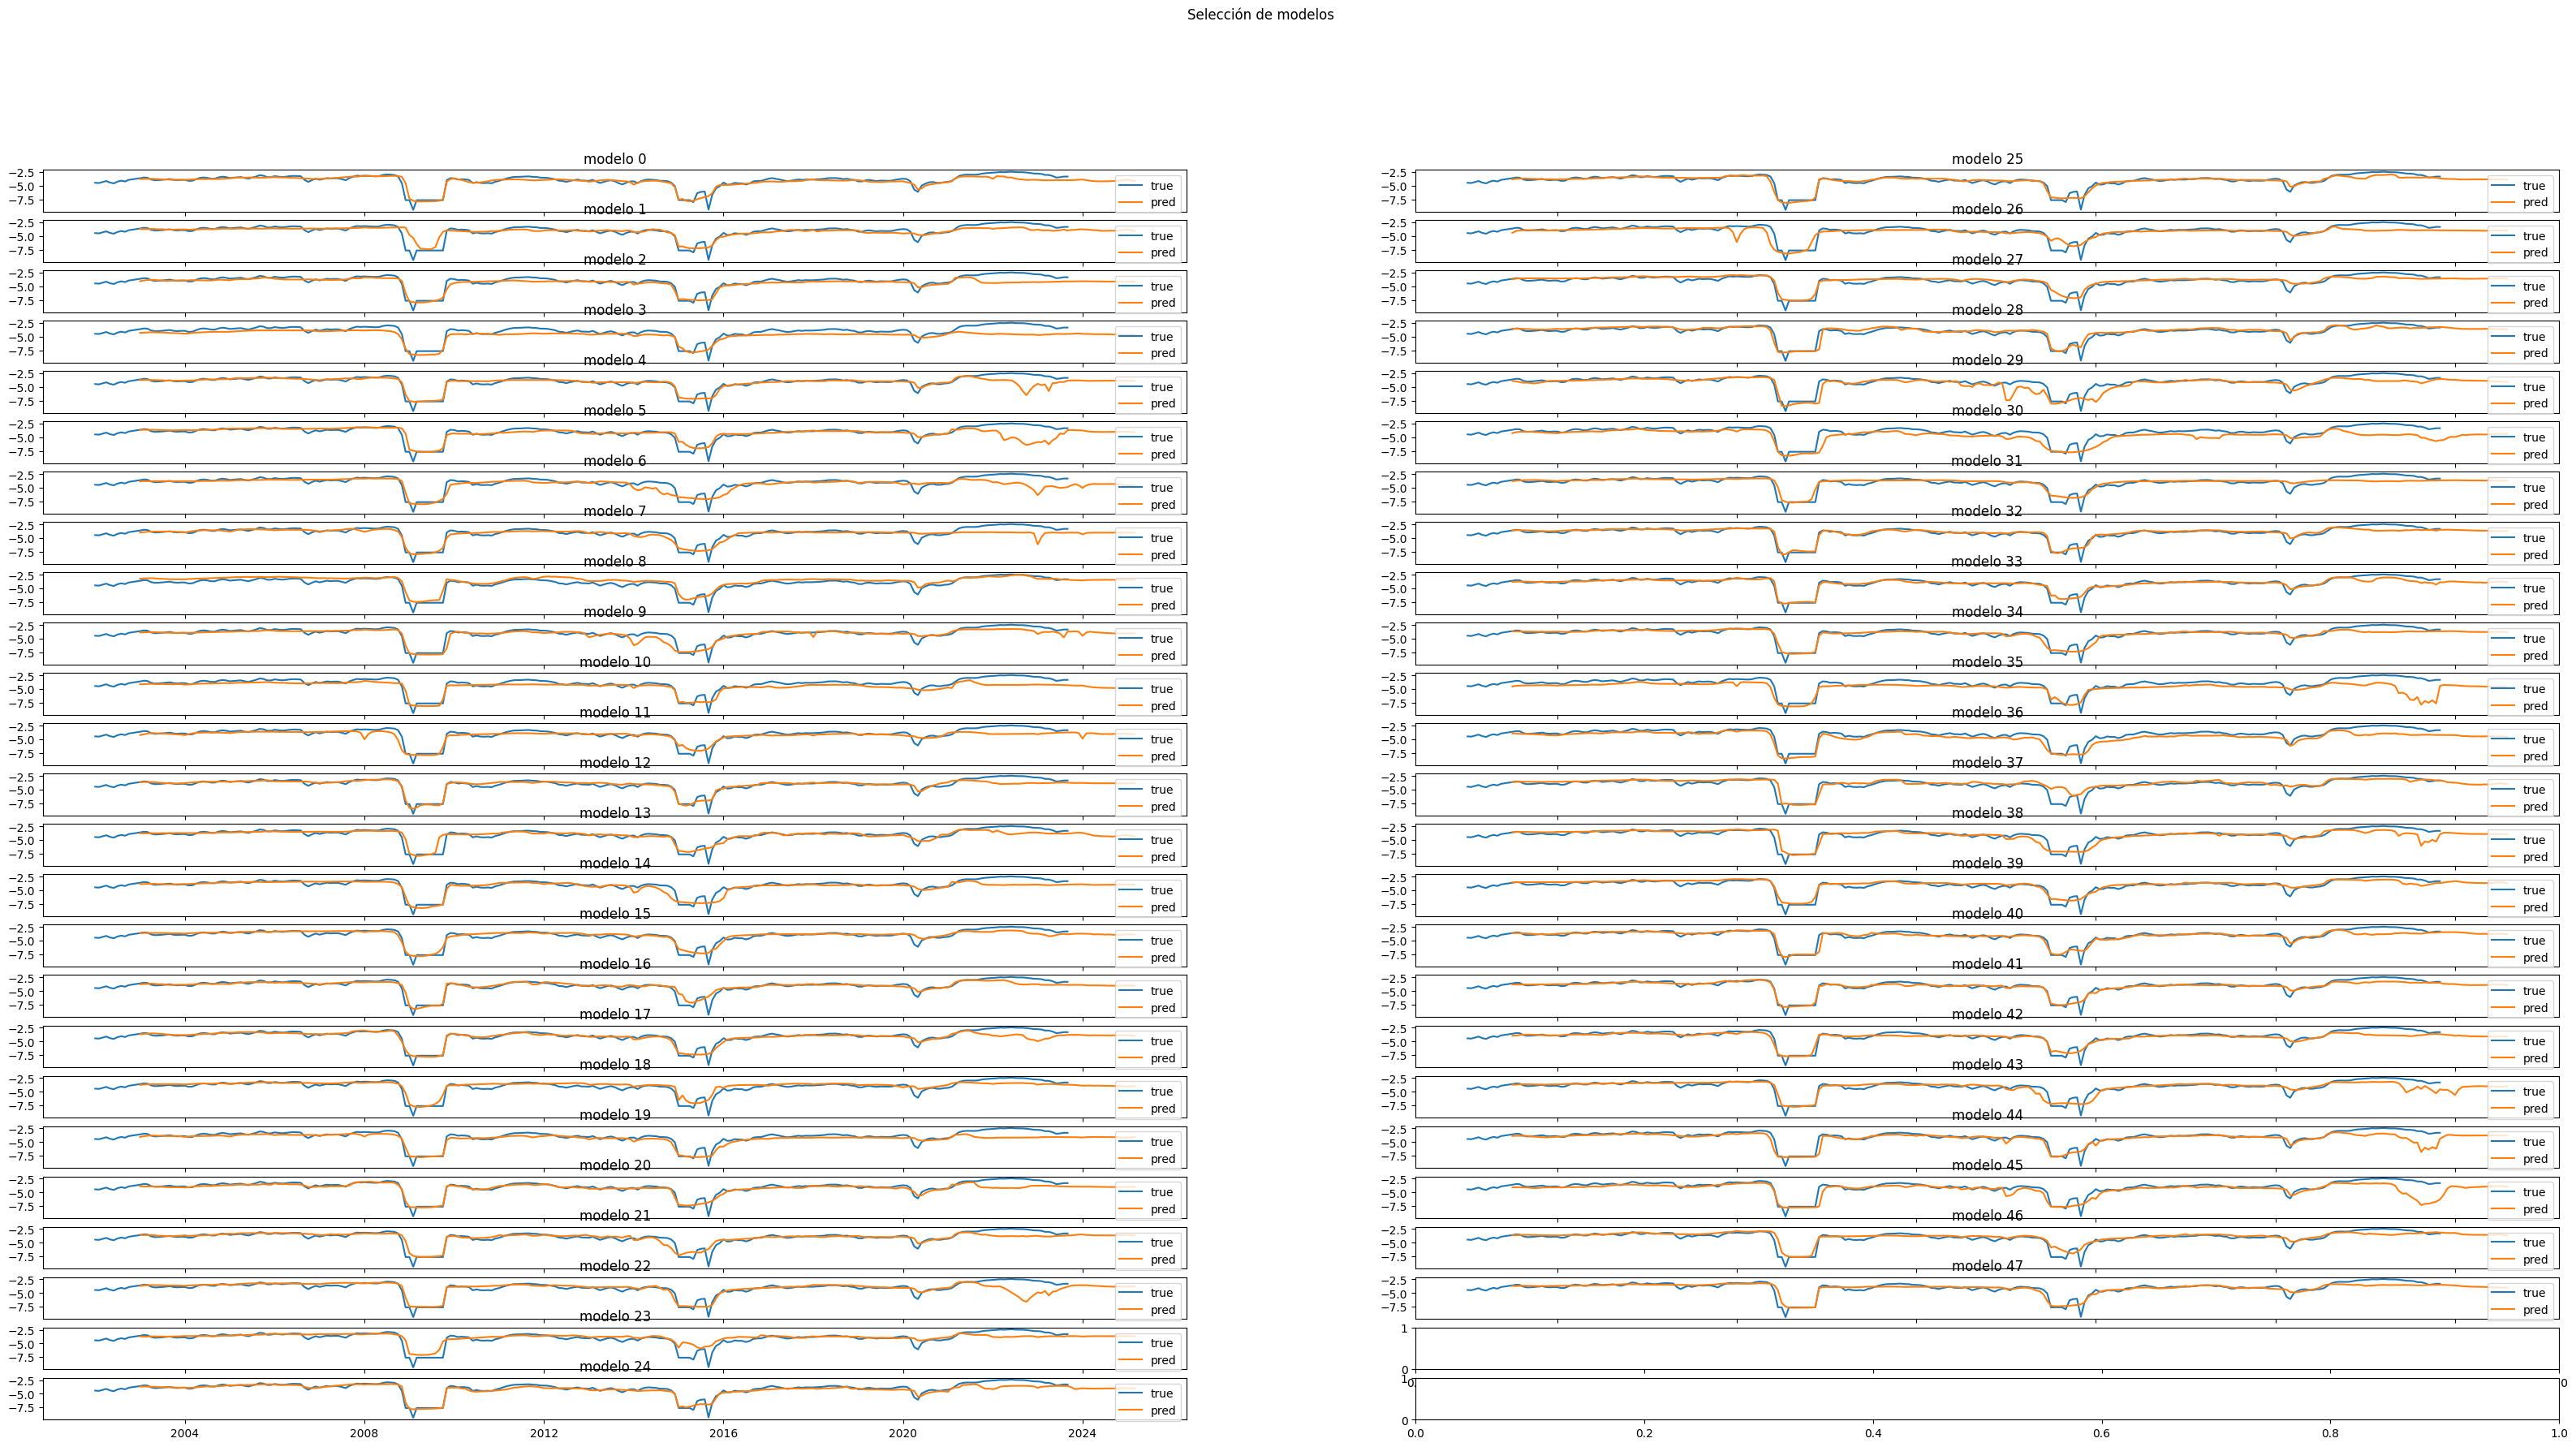

In [ ]:
var1='Inflación EEUU'
modelo1=modelo_infeu_lstm

import matplotlib.pyplot as plt
mods1=list(range(25))
mods2=list(range(25,48))
fig, axs = plt.subplots(len(mods1),2,figsize=(40,20), sharey=False)

x1=explicativas1.index
x2=prelim1.index[convol:]
for j in range(len(mods1)):
    axs[j,0].plot(x1,explicativas1[var1],x2,modelo1[2][mods1[j]])
    axs[j,0].legend(['true','pred'])
    axs[j,0].set_title(str('modelo '+str(mods1[j])))
for j in range(len(mods2)):
    axs[j,1].plot(x1,explicativas1[var1],x2,modelo1[2][mods2[j]])
    axs[j,1].legend(['true','pred'])
    axs[j,1].set_title(str('modelo '+str(mods2[j])))
fig.suptitle('Selección de modelos')
plt.show()


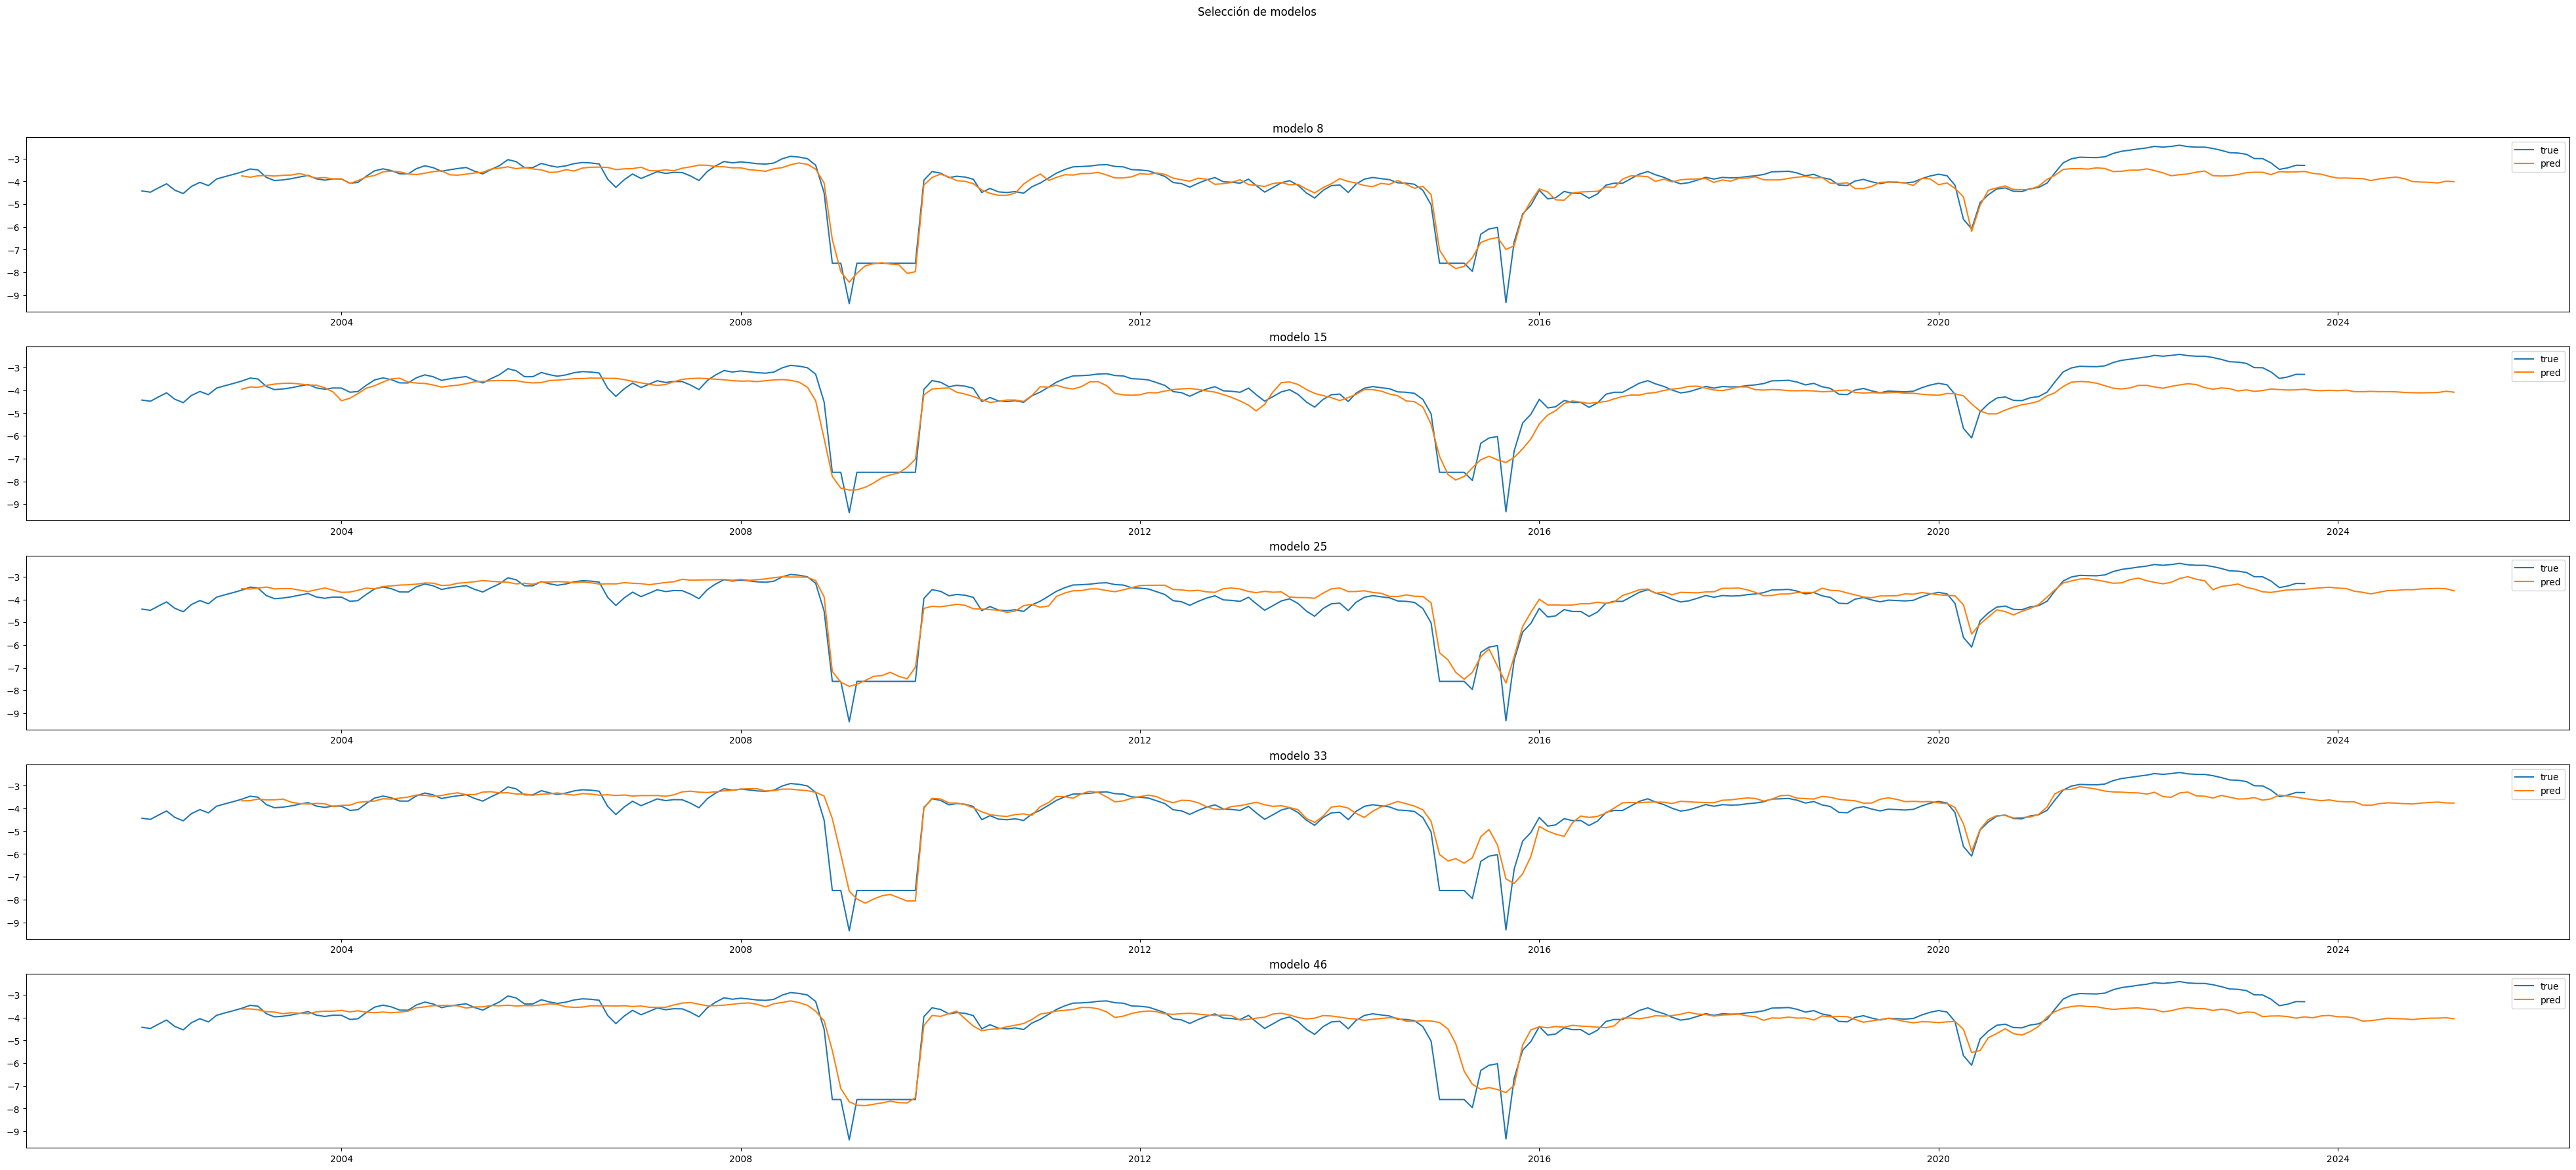

In [ ]:
import matplotlib.pyplot as plt
#mejores modelos
#IGAE RNN: 8,17,25,28,40,44;LSTM 44,0,4,16,46
#Remesas RNN 23,43,33 LSTM 19,7,15,22,41
#IFB RNN 20,13,17,20,23,29,31,33,41 LSTM 20,10,23,36,42,47
#USDMXN RNN 36,0,8,9,24,29,32 LSTM 20,0,16,21
#INPC RNN 46,1,5,7,16,23,41 LSTM 28,1,14,37,43
#Ingresos tributarios RNN 36,12,4,8,13,27,30,38 LSTM 16,8,31,37,1,2,11,14,20,25,41
# Cuenta corriente RNN 8,4,16,32,33,36,45 LSTM 29,4,12,16,24,38
#Subsidios gob federal RNN 6,0,2,10,16,18,20,26,27,33,39,44 LSTM 8,0,1,13,20,26,28,30,35,37
#Salarios RNN 24,0,4,18,25,41 LSTM 26,0,32,31
#Fondeo RNN 25,13,37,45 LSTM 1,6,30,37
#Producción industrial EEUU RNN 20,8,16,36,45 LSTM 4,20,21,44
#Construcción EEUURNN 20,0,4,16,22,23,28,32,40,44 LSTM 25,0,20,23,37
#Manufacturas EEUU RNN 20,1,4,16,21,22,23,29,44 LSTM 21,8,26,28
#Nómina no agrícola RNN 9,18,40 LSTM 16,43
#Inflación EEUU RNN 26,9,16,23,37,44 LSTM 25,8,15,33,46

mods1=list([8,15,25,33,46])
fig, axs = plt.subplots(len(mods1),1,figsize=(50,20), sharey=False)
var2=var1
modelo2=modelo_infeu_rnn

x1=explicativas1.index
x2=prelim1.index[convol:]
for j in range(len(mods1)):
    axs[j].plot(x1,explicativas1[var2],x2,modelo2[2][mods1[j]])
    axs[j].legend(['true','pred'])
    axs[j].set_title(str('modelo '+str(mods1[j])))

fig.suptitle('Selección de modelos')
plt.show()



In [ ]:
especif1=[]
for i in range(len(grids1['nodo_in'])):
    for j in range(len(grids1['nodos'])):
        for k in range(len(grids1['epocas'])):
            for l in range(len(grids1['batches'])):
                especif1.append([grids1['epocas'][k],grids1['batches'][l],grids1['nodo_in'][i],grids1['nodos'][j],grids1['activac'][j]])
especif1[4]

[100, 4, 32, [64, 64, 64], ['sigmoid', 'sigmoid', 'relu']]

In [ ]:
explicativas1.columns

Index(['IGAE', 'Remesas', 'USDMXN', 'Inversión fija bruta', 'Inflación MX',
       'Tasa de fondeo', 'Producción industrial EEUU', 'Construcción EEUU',
       'Producción manufacturera EEUU', 'Nómina no agrícola EEUU',
       'Inflación EEUU', 'Cuenta corriente MX'],
      dtype='object')

## Sección para correr el mejor modelo seleccionado

In [ ]:
from sklearn.metrics import mean_squared_error
def crear_predict(var,modelo,tipo,num):
    x1,y1=x_y_split(prelim1,var)
    x1,y1=build_dataset(x1,y1,convol)
    rnn_train=mean_squared_error(modelo[2][num].iloc[:-48],explicativas1[var].iloc[convol:-30],squared=False)
    rnn_test=mean_squared_error(modelo[2][num].iloc[-49:-18],explicativas1[var1].iloc[-31:],squared=False)
    return rnn_train,rnn_test,pd.DataFrame(modelo[2][num]).apply(lambda x:np.exp(x)).set_index(prelim1.index[convol:]).set_axis([tipo+' '+var],axis=1)

rmse1_x1,rmse2_x1,pred_var_rnn=crear_predict(var1,modelo_infeu_rnn,'RNN',26)
rmse1_x2,rmse2_x2,pred_var_lstm=crear_predict(var1,modelo_infeu_lstm,'LSTM',25)
rmse_tabla=pd.DataFrame([[rmse1_x1,rmse1_x2],[rmse2_x1,rmse2_x2]],index=['RNN','LSTM'],columns=['RMSE train','RMSE test'])

In [ ]:
var0=var1
with pd.ExcelWriter('estancia_'+var0+'2312.xlsx') as writer:
    pred_var_rnn.to_excel(writer,sheet_name='rnn_'+var0)
    pred_var_lstm.to_excel(writer,sheet_name='lstm_'+var0)
    rmse_tabla.to_excel(writer,sheet_name='rmse_'+var0)


In [ ]:
prelim.apply(lamda x:predict_in_sample(x))